In [1]:
import pandas as pd
import numpy as np
import argparse
import random
from model import KGCN
from data_loader import DataLoader
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
# prepare arguments (hyperparameters)
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='music', help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=20, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')

args = parser.parse_args(['--l2_weight', '1e-4'])

In [3]:
# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset

Construct knowledge graph ... Done
Build dataset dataframe ... Done


,userID,itemID,label
0,1217,289,1
1,1648,1308,0
2,596,8499,0
3,475,57,1
4,1450,5021,0
...,...,...,...
42341,1778,8978,0
42342,519,4,1
42343,1487,2879,1
42344,1115,36,1


In [4]:
# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, item_id, label

In [5]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args.ratio, shuffle=False, random_state=999)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

In [6]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print('device: ', device)

device:  cuda


In [7]:
# train
loss_list = []
test_loss_list = []
auc_score_list = []

for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    
    # print train loss per every epoch
    print('[Epoch {}]train_loss: '.format(epoch+1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))
        
    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        print('[Epoch {}]test_loss: '.format(epoch+1), test_loss / len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))

[Epoch 1]train_loss:  0.9948683188589706
[Epoch 1]test_loss:  0.8900299510865841
[Epoch 2]train_loss:  0.7909426585585583
[Epoch 2]test_loss:  0.7441599297073652
[Epoch 3]train_loss:  0.7068951623523089
[Epoch 3]test_loss:  0.7067407547302966
[Epoch 4]train_loss:  0.6913421748942986
[Epoch 4]test_loss:  0.6997240664824
[Epoch 5]train_loss:  0.6877898849103674
[Epoch 5]test_loss:  0.6974473530391477
[Epoch 6]train_loss:  0.6854950508720139
[Epoch 6]test_loss:  0.6960476396218785
[Epoch 7]train_loss:  0.6831088630628541
[Epoch 7]test_loss:  0.6948170353781502
[Epoch 8]train_loss:  0.6799849664635879
[Epoch 8]test_loss:  0.6932615316139077
[Epoch 9]train_loss:  0.6746182795174286
[Epoch 9]test_loss:  0.6899305672015784
[Epoch 10]train_loss:  0.6628341283631617
[Epoch 10]test_loss:  0.6797543051107875
[Epoch 11]train_loss:  0.6344318608274091
[Epoch 11]test_loss:  0.6505626156645001
[Epoch 12]train_loss:  0.5781617601093422
[Epoch 12]test_loss:  0.5969738592516701
[Epoch 13]train_loss:  0.

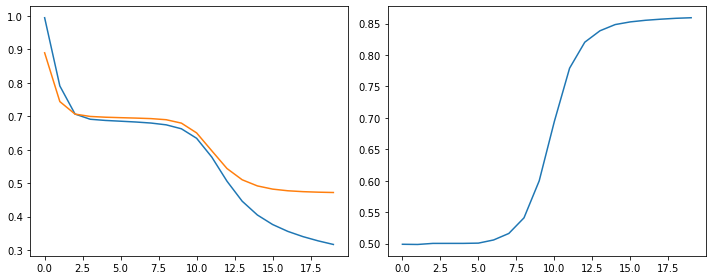

In [8]:
# plot losses / scores
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
ax1.plot(loss_list)
ax1.plot(test_loss_list)
ax2.plot(auc_score_list)

plt.tight_layout()